In [15]:
from collections import deque
import heapq as hq

class Order: 
    _id_counter = 0 

    def __init__(self, price=None, volume=100, is_bid=True, is_market=False):
        self.price = price 
        self.volume = volume 
        self.is_bid = is_bid
        self.id = Order._id_counter
        Order._id_counter += 1

        #is_market flag for a market order
        self.is_market = is_market

class PriceLevel:
    def __init__(self, price):
        self.price = price 
        self.orders = deque()
    
    def add(self, order):
        self.orders.append(order)

    def top(self):
        if not self.orders:
            return None
        return self.orders[0] # O(1)

    def pop(self):
        if not self.orders:
            raise IndexError("Price level is empty.")
        return self.orders.popleft() # O(1)
    
    def fill(self, volume):
        to_fill = volume
        filled = 0

        while not self.is_empty(): 
            top_order = self.top()

            if top_order.volume > to_fill: 
                filled += to_fill
                top_order.volume -= to_fill
                to_fill = 0 
                break

            elif top_order.volume == to_fill: 
                filled += to_fill 
                self.pop()
                to_fill = 0 
                break

            else: 
                filled += top_order.volume
                to_fill -= top_order.volume
                self.pop()

        return filled
        

    def cancel(self, order):
        try:
            self.orders.remove(order) # O(n)
        except ValueError:
            raise ValueError("Order not found at this price level.")
        
    def is_empty(self):
        return True if len(self.orders) == 0 else False

class PriceBook:
    def __init__(self, is_bid_side):
        self._price_levels = {}
        self._heap = []
        self.is_bid_side = is_bid_side

    def add(self, order): 
        price = order.price

        if price not in self._price_levels:
            self._price_levels[price] = PriceLevel(price)
            # Use negative price for max-heap behavior on bid side.
            heap_price = -price if self.is_bid_side else price
            hq.heappush(self._heap, heap_price)

        self._price_levels[price].add(order)
    
    def cancel(self, order):
        price = order.price
        if price not in self._price_levels:
            raise ValueError(f"Price {price} not found in PriceBook.")

        try:
            self._price_levels[price].cancel(order)
            # Trying to remove the price level from the heap here would be O(N)
        except ValueError as e:
            # Propagate the original error — don't swallow it
            raise ValueError(f"Failed to cancel order {order.id}: {e}") from e

    def best_price(self):
        if not self._price_levels: 
            return None
        else:
            # Since I didn't remove empty price levels upon order cancellation I have to handle it here
            while self._heap:
                best_price = - self._heap[0] if self.is_bid_side else self._heap[0]
                # Remove empty price levels
                if self._price_levels[best_price].is_empty():
                    hq.heappop(self._heap)
                    del self._price_levels[best_price]
                else: 
                    break

            if self._heap:
                return best_price
            else:
                return None
            
    def peek_best_order(self):
        best_price = self.best_price()
        if best_price:
            return self._price_levels[best_price].top()
        else:
            return None
        
    def fill_volume(self, volume, price): 
        to_fill = volume
        filled = {}
        best_price = self.best_price()

        while best_price and to_fill > 0:
            
            # Check whether prices are compatible
            can_fill = (best_price >= price) if self.is_bid_side else (best_price <= price)

            if can_fill:
                filled_at_price = self._price_levels[best_price].fill(to_fill)
                to_fill -= filled_at_price
                filled[best_price] = filled_at_price
            else:
                break
            
            # This simultaneously removes empty price levels and establishes next best_price
            best_price = self.best_price()

        # Return a dictionary price -> volume filled at price
        return filled
        
class OrderBook:
    def __init__(self, intrinsic_value=100):
        self.bids = PriceBook(is_bid_side=True)
        self.asks = PriceBook(is_bid_side=False)
        self.order_map = dict()
        self.intrinsic_value = intrinsic_value

        # Volume traded in a timestep 
        self.buy_volume = 0
        self.sell_volume = 0
    
    @property
    def best_bid(self):
        return self.bids.best_price()
    
    @property
    def best_ask(self):
        return self.asks.best_price()
    
    @property 
    def spread(self):
        if self.best_bid == None or self.best_ask == None:
            return None
        else: 
            return round(self.best_ask-self.best_bid, 2)
    
    @property 
    def mid_price(self):
        if self.best_bid == None or self.best_ask == None:
            return None
        else: 
            return round((self.best_ask + self.best_bid) / 2, 2)
    
    def process_order(self, order):

        if order.is_bid: 
            filled = self.asks.fill_volume(order.volume, order.price)
        else:
            filled = self.bids.fill_volume(order.volume, order.price)
        
        filled_volume = sum(filled.values())

        # Only add remaining volume to book if it is a limit order
        if filled_volume < order.volume and not order.is_market:
            order.volume -= filled_volume
            self.order_map[order.id] = order

            if order.is_bid:
                self.bids.add(order)
            else:
                self.asks.add(order)
        
        # Update aggresive volumes traded this timestep 
        if order.is_bid:
            self.buy_volume += filled_volume
        else:
            self.sell_volume += filled_volume 
        
        return filled
    
    # A helper function to reset the trading volumes at each timestep
    def reset_volumes(self):
        self.buy_volume = 0 
        self.sell_volume = 0

    def cancel(self, order_id):
        try: 
            order = self.order_map[order_id]
        except KeyError as e: 
            raise KeyError(f"Order with id {order_id} could not be found: {e}")

        if order.is_bid:
            self.bids.cancel(order)
        else:
            self.asks.cancel(order)

        del self.order_map[order_id]

In [102]:
import random as rd
import numpy as np

class OrderFlow: 
    rng = np.random.default_rng(seed=42)

    def __init__(self, arrival_rate=100, max_offset=1.0, sigma=0.1, min_volume=10, max_volume=100, market_frac=0.1, imb_coeff=0.7, ar_decay=0.7):
        self.arrival_rate = arrival_rate
        self.max_offset = max_offset

        # Remove is_bid_prob since uninformed flow should be neutral
        # self.is_bid_prob = is_bid_prob

        # Base price is determined by order book mid price
        # self.base_price = base_price
        self.sigma = sigma
        self.min_volume = min_volume
        self.max_volume = max_volume

        # Introduce aggressive traders
        self.market_frac = market_frac

        # Impact of trade momentum on bid probability of informed traders
        self.imb_coeff = imb_coeff
        # Informed traders will decide whether to bid based on an autoregressive volume signal
        self.ar_imb = 0
        self.ar_decay = ar_decay
    
    def update_signal(self, order_book):
        if order_book.buy_volume + order_book.sell_volume == 0:
            imbalance = 0
        else:
            imbalance = (order_book.buy_volume - order_book.sell_volume)/(order_book.buy_volume + order_book.sell_volume)
        
        # Standard AR(1): mean-reverting to 0
        self.ar_imb = self.ar_decay * self.ar_imb + (1 - self.ar_decay) * self.imb_coeff * imbalance
        
    def generate_orders(self, order_book): 
        n_orders = OrderFlow.rng.poisson(self.arrival_rate)
        orders = []

        # mid_price replaces base_price.
        if order_book.mid_price is None:
            # Fallback for when book is empty (intrinsic value of security)
            mid_price = order_book.intrinsic_value
        else:
            mid_price = order_book.mid_price
        
        for _ in range(n_orders):

            # Simulate aggressive flow
            if self.market_frac > 0:
                is_market = OrderFlow.rng.random() < self.market_frac
            else:
                is_market = False
            
            # If the bid is part of aggressive flow skew bid frac, and increase volume.
            if is_market:
                # Bid probability scales with the the signal
                bid_prob = 0.5 + 0.5 * np.tanh(2 * self.ar_imb)
                is_bid = OrderFlow.rng.random() < bid_prob

                # Increase the volume as a function of imbalance magnitude.
                min_volume = self.min_volume * (1 + abs(self.ar_imb))
                max_volume = self.max_volume * (1 + abs(self.ar_imb))
                volume = OrderFlow.rng.integers(min_volume, max_volume + 1)

                # Price is placed as high (low) as possible so they always cross the spread, even with slippage.
                price = float('inf') if is_bid else -float('inf')

            else: 
                # Neutral bids are generated as before
                normal = OrderFlow.rng.normal(0, self.sigma)
                offset = OrderFlow.rng.uniform(0, self.max_offset)
                is_bid = OrderFlow.rng.random() < 0.5
            
                if is_bid:
                    price = mid_price + normal - offset
                else: 
                    price = mid_price + normal + offset

                price = round(price, 2) 
                volume = OrderFlow.rng.integers(self.min_volume, self.max_volume + 1)

            orders.append(Order(price, volume, is_bid, is_market))
        
        return orders

In [103]:
import random as rd
import numpy as np

class OrderFlow2: 
    rng = np.random.default_rng(seed=42)

    def __init__(self, arrival_rate=100.0, max_offset=1.0, is_bid_prob=0.5, base_price=100, sigma=0.1, min_volume=10, max_volume=100):
        self.arrival_rate = arrival_rate
        self.max_offset = max_offset
        self.is_bid_prob = is_bid_prob
        self.base_price = base_price
        self.sigma = sigma
        self.min_volume = min_volume
        self.max_volume = max_volume
        
    def generate_orders(self, order_book): 
        n_orders = OrderFlow2.rng.poisson(self.arrival_rate)
        orders = []

        if order_book.mid_price is None:
            # Fallback for when book is empty (intrinsic value of security)
            mid_price = order_book.intrinsic_value
        else:
            mid_price = order_book.mid_price
        
        for _ in range(n_orders):
            
            # Normally distributed price
            normal = OrderFlow2.rng.normal(0, self.sigma)
            offset = OrderFlow2.rng.uniform(0, self.max_offset)
            is_bid = OrderFlow2.rng.random() < self.is_bid_prob

            if is_bid:
                price = mid_price + normal - offset
            else: 
                price = mid_price + normal + offset
            
            # We round to the cent/penny as per most exchanges
            price = round(price, 2) 
            
            # Random order volume
            volume = OrderFlow2.rng.integers(self.min_volume, self.max_volume + 1)
            orders.append(Order(price, volume, is_bid, False))
        
        return orders

In [116]:
class SimpleMarketMaker():
    def __init__(self, inventory_limit=float('inf'), quote_size=1000):
        self.inventory = 0
        self.cash = 0
        self.active_orders = {}

        self.inventory_limit = inventory_limit
        self.quote_size = quote_size
    
    def update(self, order_book):
        # First we check whether orders on the previous times tep were filled 
        for order_id, (price, volume, is_bid) in list(self.active_orders.items()):
            
            # Check for full fills 
            if order_id not in order_book.order_map:
                self._record_fill(price, volume, is_bid)
                del self.active_orders[order_id]

            # Check for partial fills  
            else: 
                remaining_volume = order_book.order_map[order_id].volume

                if remaining_volume == 0:
                    raise ValueError("A filled order remained on the books.")
                
                elif remaining_volume > volume:
                    raise ValueError("Order book's volume exceeds our count.")
                
                else: 
                    filled_volume = volume - remaining_volume 
                    self._record_fill(price, filled_volume, is_bid)
                    self.active_orders[order_id] = (price, remaining_volume, is_bid)
                
        # Generate an order via a strategy 
        orders = self.strategy(order_book)

        # Post Quote
        for order in orders:
            order_book.process_order(order)
            self.active_orders[order.id] = (order.price, order.volume, order.is_bid)
    
    def _record_fill(self, price, volume, is_bid):
        if is_bid: 
            self.cash -= price * volume 
            self.inventory += volume
        else:
            self.cash += price * volume 
            self.inventory -= volume 
    
    def strategy(self, order_book):
        orders = []
        tick = 0.01
        if order_book.best_ask == None or order_book.best_bid == None:
            ask = order_book.intrinsic_value + tick
            bid = order_book.intrinsic_value - tick
        else:
            ask = round(order_book.best_ask - tick, 2)
            bid = round(order_book.best_bid + tick, 2)

        # Basic Strategy: if too long we stop quoting bids, if too short we stop quoting asks.
        # If we have unfilled orders on the book replace them with new quotes
        for order_id in list(self.active_orders.keys()):
            try:
                order_book.cancel(order_id)
                del self.active_orders[order_id]
            except:
                # Order may already be filled (this exception shouldn't ever trigger.)
                pass

        if self.inventory < self.inventory_limit:
            orders.append(Order(bid, self.quote_size, True, False))

        if self.inventory > -self.inventory_limit:
            orders.append(Order(ask, self.quote_size, False, False))

        return orders
    
    def pnl(self, order_book):
        if order_book.mid_price: 
            unrealised_pnl = self.inventory * order_book.mid_price
        else:
            unrealised_pnl = 0 
        total_pnl = self.cash + unrealised_pnl
        return total_pnl
    
    def get_stats(self):
        return {
            "Inventory" : self.inventory,
            "Cash" : self.cash
        }

mid price under OrderFlow: [100.09 100.09 100.08 ...  99.66  99.66  99.66]
mid price under OrderFlow2: [100.03 100.05 100.05 ... 100.04 100.04 100.05]


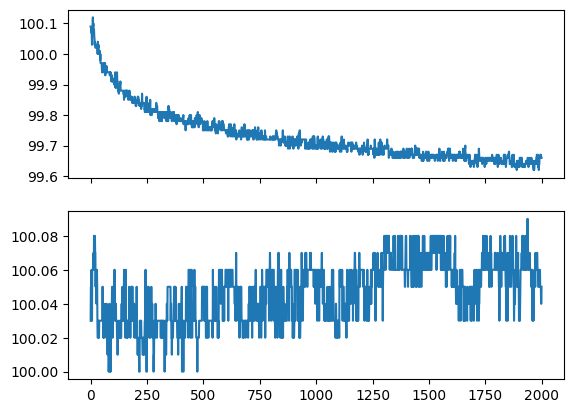

In [117]:
import matplotlib.pyplot as plt
mm = SimpleMarketMaker()
mm2 = SimpleMarketMaker()
of = OrderFlow(market_frac=0.05)
of2 = OrderFlow2()
ob = OrderBook()
ob2 = OrderBook()
OrderFlow.rng = np.random.default_rng(seed=42)
OrderFlow2.rng = np.random.default_rng(seed=42)


def simulate(order_book, order_flow, market_maker, timesteps):
    pnl = np.zeros(timesteps)
    mp = np.zeros_like(pnl)

    for t in range(timesteps):
        # Simulate order flow 
        orders = order_flow.generate_orders(order_book)
        for order in orders:
            order_book.process_order(order)

        # Update order flow signal
        if hasattr(order_flow, 'update_signal'):
            order_flow.update_signal(order_book)
        
        # Market Maker updates quotes
        market_maker.update(order_book)

        # Market Maker updates pnl
        pnl[t] = market_maker.pnl(order_book)
        mp[t] = order_book.mid_price if order_book.mid_price is not None else order_book.intrinsic_value
    
    return pnl, mp

pnl, mp = simulate(ob, of, mm, 2000)
pnl2, mp2 = simulate(ob2, of2, mm2, 2000)
fig, [ax_1, ax_2] = plt.subplots(nrows=2, sharex=True)
ax_1.plot(mp)
ax_2.plot(mp2)

print(f"mid price under OrderFlow: {mp}")
print(f"mid price under OrderFlow2: {mp2}")



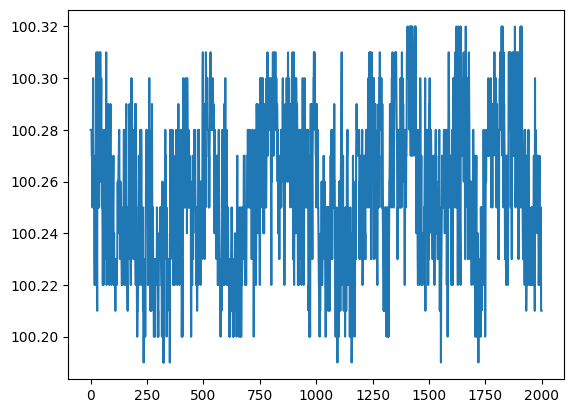

In [115]:
pnl, mp = simulate(ob, of, mm, 2000)
plt.plot(mp)